# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
# azdias.shape
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

feat_info.T


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
information_level,person,person,person,person,person,person,person,person,person,person,...,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,community,community,community
type,categorical,ordinal,categorical,categorical,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,...,ordinal,ordinal,ordinal,ordinal,mixed,ordinal,ordinal,ordinal,ordinal,ordinal
missing_or_unknown,"[-1,0]","[-1,0,9]","[-1,0]",[0],[-1],[-1],[-1],[-1],[-1],[-1],...,[-1],[-1],[-1],[-1],"[-1,0]",[-1],[-1],"[-1,9]","[-1,0]","[-1,9]"
missing_or_unknown_list,"[-1, 0]","[-1, 0, 9]","[-1, 0]",[0],[-1],[-1],[-1],[-1],[-1],[-1],...,[-1],[-1],[-1],[-1],"[-1, 0]",[-1],[-1],"[-1, 9]","[-1, 0]","[-1, 9]"


In [6]:
for attribute,missing_values_list in zip(feat_info["attribute"], feat_info["missing_or_unknown_list"]):
    if missing_values_list[0] != "": # if the list not empty 
        for missing_value in missing_values_list:
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan

In [7]:
# azdias

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:

missing_data = azdias.isnull().sum()
missing_data.sort_values(ascending=True, inplace=True)

In [9]:
missing_data = missing_data/(azdias.shape[0])*100

In [10]:
missing_data

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

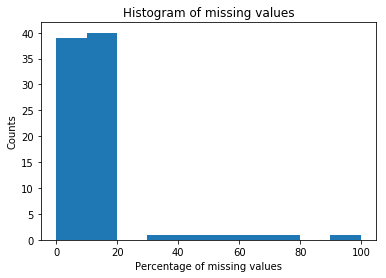

In [11]:
# Plot a histogram of missing data
plt.hist(missing_data)

plt.xlabel('Percentage of missing values')
plt.ylabel('Counts')
plt.title('Histogram of missing values')
plt.show()

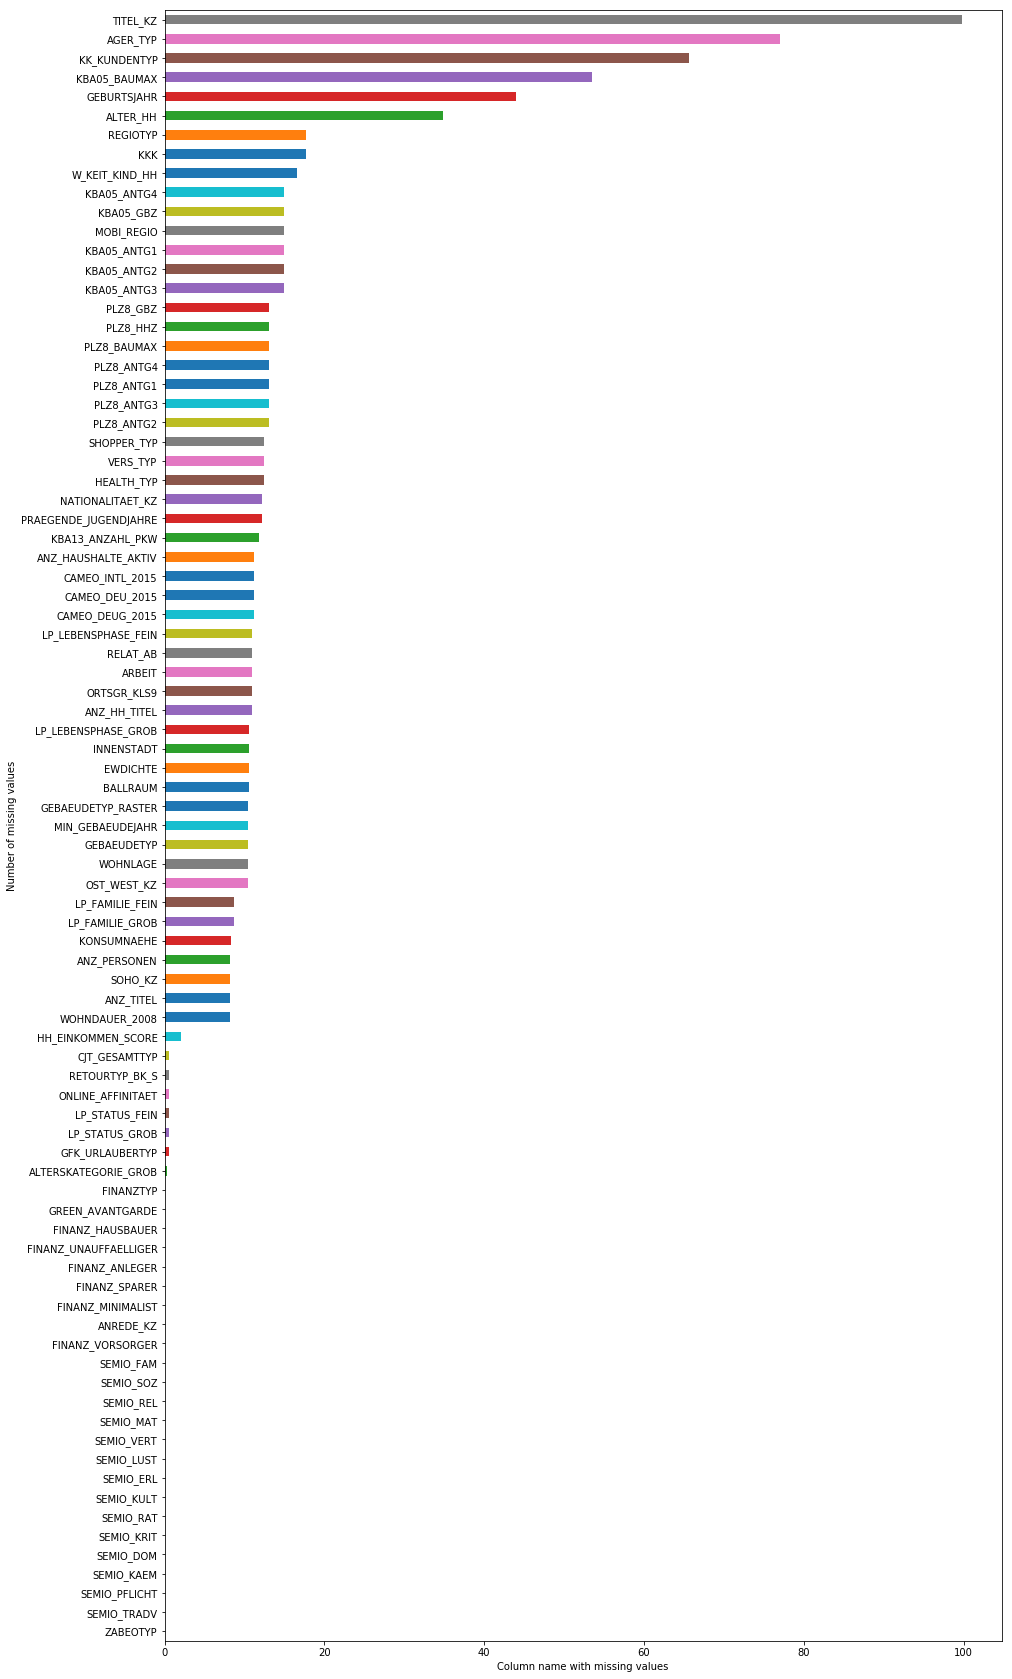

In [12]:
# Investigate patterns in the amount of missing data in each column.

missing_data.plot.barh(figsize=(15,30))
plt.xlabel('Column name with missing values')
plt.ylabel('Number of missing values')

plt.show()

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = missing_data[missing_data>20].index
azdias.drop(columns=outlier_columns,axis="columns",inplace=True)


In [14]:
print(outlier_columns )

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')


#### Discussion 1.1.2: Assess Missing Data in Each Column

The outlier columns are: 'KK_KUNDENTYP', 'GEBURTSJAHR', 'AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX' and 'TITEL_KZ'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

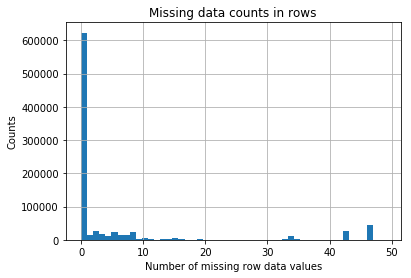

In [15]:
# How much data is missing in each row of the dataset?
missing_row_data = azdias.isnull().sum(axis=1)

plt.hist(missing_row_data, bins=50)

plt.xlabel('Number of missing row data values')
plt.ylabel('Counts')
plt.title('Missing data counts in rows')
plt.grid(True)
plt.show()

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_less_30 = azdias[missing_row_data < 30].reset_index(drop=True)
missing_above_30 = azdias[missing_row_data >= 30].reset_index(drop=True)

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
top_few_missing_cols=missing_data[missing_data < 30].index[:5]


In [18]:
top_few_missing_cols

Index(['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM'], dtype='object')

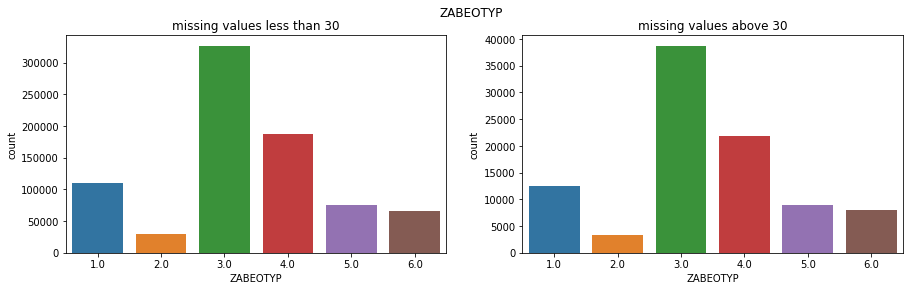

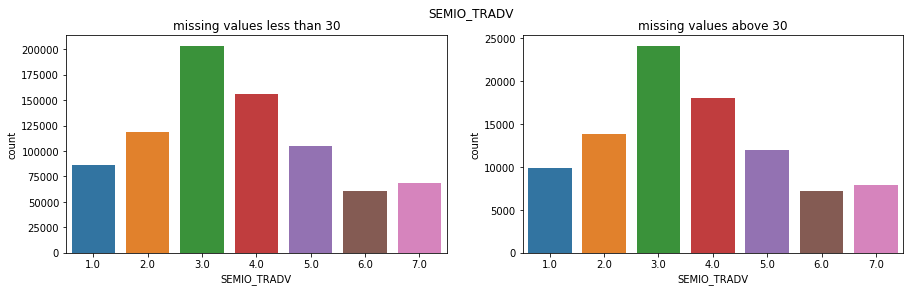

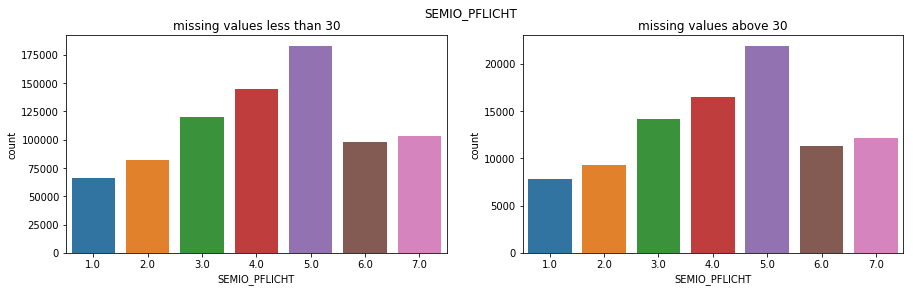

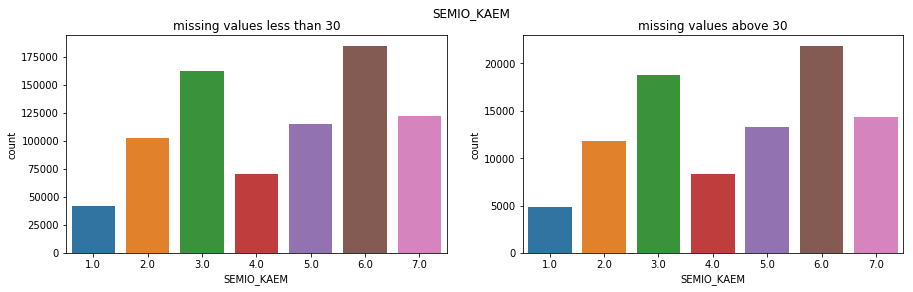

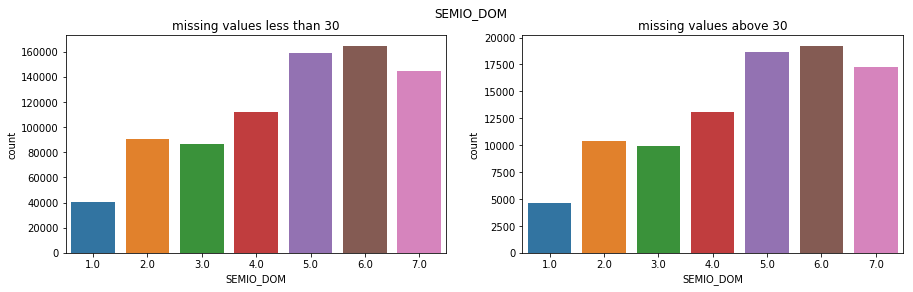

In [19]:
def create_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('missing values less than 30')
    sns.countplot(x=azdias.loc[missing_less_30.index,column],ax=ax1)

    ax2.set_title('missing values above 30')
    sns.countplot(x=azdias.loc[missing_above_30.index,column],ax=ax2)
    
    fig.suptitle(column)
    plt.show()

for i in range(top_few_missing_cols.size):
    create_plot(top_few_missing_cols[i])

In [20]:
# Dropping rows with high missing value
azdias_high_missing = azdias.iloc[missing_above_30.index]

print(f'Total rows in azdias dataset is {azdias.shape[0]}')

# dropping rrows with high missing values
azdias = azdias[~azdias.index.isin(missing_above_30.index)]
azdias.head()

print(f'{len(azdias_high_missing)} rows greater than 30% in missing row values were dropped')
print(f'{azdias.shape[0]} rows are remaining')

Total rows in azdias dataset is 891221
93160 rows greater than 30% in missing row values were dropped
798061 rows are remaining


#### Discussion 1.1.3: Assess Missing Data in Each Row

We separate the data in two datasets, the first one data with less than 30 columns null and the second one with 30 or more columns null, then we plot them on the columns with less or any missing values that are: [ 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_DOM'].

We can see in the results that it's not qualitatively different from data with few or no missing values then we deleted those rows from the azdias dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info[feat_info.type == 'categorical'].attribute

categorical_features = categorical_features[ ~categorical_features.isin(outlier_columns)]

print(categorical_features)


2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [23]:
binary_categories_columns=[]
multi_level_columns=[]

for col in categorical_features:
    if azdias[col].nunique()==2:
        binary_categories_columns.append(col)
    else:
        multi_level_columns.append(col)

In [24]:
for column in binary_categories_columns:
    print(azdias[column].value_counts())

2.0    416483
1.0    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
W    562845
O    152061
Name: OST_WEST_KZ, dtype: int64


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)


In [26]:
azdias=pd.get_dummies(data=azdias,columns=multi_level_columns)

#### Discussion 1.2.1: Re-Encode Categorical Features

We separate and transform the data in binary and re-encode the following variables:  ANREDE_KZ, OST_WEST_KZ, VERS_TYP

Finally for the multi level value columns we apply the get_dummies from Pandas to get the information.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()


14.0    169114
8.0     130583
5.0      77448
10.0     76666
3.0      49532
15.0     38166
11.0     32046
9.0      29997
6.0      23038
12.0     22019
1.0      19076
4.0      18359
2.0       6743
13.0      5192
7.0       3609
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [28]:
# Decade Mapping
decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
azdias["DECADE"]=azdias['PRAEGENDE_JUGENDJAHRE']
azdias["DECADE"].replace(decade_dic,inplace=True)


In [29]:
azdias["DECADE"].value_counts()

6.0    207280
4.0    160580
5.0    135923
3.0    104095
2.0     67891
1.0     25819
Name: DECADE, dtype: int64

In [30]:
movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
azdias["MOVEMENT"]=azdias['PRAEGENDE_JUGENDJAHRE']
azdias["MOVEMENT"].replace(movement_dic,inplace=True)
azdias["MOVEMENT"].value_counts()

1.0    544438
0.0    157150
Name: MOVEMENT, dtype: int64

In [31]:
azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE'],axis="columns",inplace=True)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'].value_counts()

51    119440
41     82652
24     81698
14     56520
43     50682
54     40543
25     35537
22     29722
23     24124
13     23541
45     23446
55     21523
52     18340
31     17052
34     16629
15     15218
44     13291
12     11870
32      9297
35      9288
33      8902
Name: CAMEO_INTL_2015, dtype: int64

In [33]:
def transform_wealth(x):
    return x // 10

# Life stage feature
def transform_life_stage(x):
    return x % 10

In [34]:
azdias['WEALTH'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])
azdias['LIFE_STAGE'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])

azdias['WEALTH'] = azdias['WEALTH'].apply(transform_wealth)
azdias['LIFE_STAGE'] = azdias['LIFE_STAGE'].apply(transform_life_stage)

In [35]:
# Validate Wealth and Life_Stage
azdias['WEALTH'].value_counts()
azdias['LIFE_STAGE'].value_counts()

1.0    219144
4.0    208681
3.0    107249
5.0    105012
2.0     69229
Name: LIFE_STAGE, dtype: int64

In [36]:
#delete the original column
azdias.drop(['CAMEO_INTL_2015'],axis=1,inplace=True)

In [37]:
azdias.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
93160,4.0,1.0,5.0,1.0,4.0,2.0,1.0,4.0,0,2.0,...,0,0,0,0,0,0,2.0,1.0,4.0,3.0
93161,3.0,0.0,5.0,1.0,4.0,1.0,1.0,3.0,1,3.0,...,0,0,0,0,0,0,3.0,0.0,1.0,5.0
93162,3.0,1.0,4.0,3.0,3.0,4.0,2.0,1.0,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,5.0
93163,2.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,4.0
93164,2.0,1.0,2.0,5.0,2.0,5.0,3.0,4.0,0,1.0,...,0,0,0,0,0,0,6.0,1.0,4.0,3.0


In [38]:
mixed_features = feat_info[feat_info.type == 'mixed'].attribute

mixed_features = mixed_features[ ~mixed_features.isin(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])]

mixed_features = mixed_features[ ~mixed_features.isin(outlier_columns)]

mixed_features

15    LP_LEBENSPHASE_FEIN
16    LP_LEBENSPHASE_GROB
56               WOHNLAGE
79            PLZ8_BAUMAX
Name: attribute, dtype: object

#### Discussion 1.2.2: Engineer Mixed-Type Features

We worked on the mixed variables: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. Nation will be discarded then it was necessary the following:

1.  For PRAEGENDE_JUGENDJAHRE we used 2 dictionarie for mapping the values due that it's not possible to get a function for doing it.


2.  For CAMEO_INTL_2015, we created 2 functions for processing WEALTH and LIFE_STAGE and created new features using the functions.


3.  Drop the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

def correlated_columns_to_drop(df, min_corr_level=0.95):

    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    return [
        column
        for column in upper.columns
        if any(upper[column] > min_corr_level)
    ]

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
columns_to_drop = correlated_columns_to_drop(azdias, 0.95)

columns_to_drop


['LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_GROB_1.0',
 'LP_FAMILIE_GROB_2.0',
 'LP_STATUS_GROB_5.0',
 'MOVEMENT']

In [41]:
for column_todrop in columns_to_drop:
    if column_todrop in mixed_features.values:
        azdias.drop(column_todrop, axis=1, inplace=True)

In [42]:
np.unique(azdias.dtypes.values)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
93160,4.0,1.0,5.0,1.0,4.0,2.0,1.0,4.0,0,2.0,...,0,0,0,0,0,0,2.0,1.0,4.0,3.0
93161,3.0,0.0,5.0,1.0,4.0,1.0,1.0,3.0,1,3.0,...,0,0,0,0,0,0,3.0,0.0,1.0,5.0
93162,3.0,1.0,4.0,3.0,3.0,4.0,2.0,1.0,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,5.0
93163,2.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,4.0
93164,2.0,1.0,2.0,5.0,2.0,5.0,3.0,4.0,0,1.0,...,0,0,0,0,0,0,6.0,1.0,4.0,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df, features):
    
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    features['missing_or_unknown_list'] = features['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

    for attribute,missing_values_list in zip(features["attribute"], features["missing_or_unknown_list"]):
        if missing_values_list[0] != "": # if the list not empty 
            for missing_value in missing_values_list:
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)

                df.loc[df[attribute] == missing_value, attribute] = np.nan
    # remove selected columns and rows, ...

    outlier_columns = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ']

    df.drop(columns=outlier_columns,axis="columns",inplace=True)
    #remove selected rows
    missing_row_data = df.isnull().sum(axis=1)
    missing_row_data.sort_values(ascending=True, inplace=True)
    missing_above_30 = df[missing_row_data >= 30].reset_index(drop=True)


    azdias_many_missing = df.iloc[missing_above_30.index]
    df = df[~df.index.isin(missing_above_30.index)]

    print(f'{len(azdias_many_missing)} rows greater than 30% in missing row values were dropped')
    print(f'{df.shape[0]} rows are remaining')

    # select, re-encode, and engineer column values.
    categorical_features = features[features.type == 'categorical'].attribute
    categorical_features = categorical_features[ ~categorical_features.isin(outlier_columns)]

    binary_categories_columns=[]
    multi_level_columns=[]

    for col in categorical_features:
        if df[col].nunique()==2:
            binary_categories_columns.append(col)
        else:
            multi_level_columns.append(col)

    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    df=pd.get_dummies(data=df,columns=multi_level_columns)

    decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    df["DECADE"]= df['PRAEGENDE_JUGENDJAHRE']
    df["DECADE"].replace(decade_dic,inplace=True)

    movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    df["MOVEMENT"]= df['PRAEGENDE_JUGENDJAHRE']
    df["MOVEMENT"].replace(movement_dic,inplace=True)

    df.drop(columns=['PRAEGENDE_JUGENDJAHRE'],axis="columns",inplace=True)
    df['WEALTH'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    df['LIFE_STAGE'] = pd.to_numeric(df['CAMEO_INTL_2015'])

    df['WEALTH'] = df['WEALTH'].apply(transform_wealth)
    df['LIFE_STAGE'] = df['LIFE_STAGE'].apply(transform_life_stage)

    df.drop(['CAMEO_INTL_2015'],axis=1,inplace=True)

    mixed_features = features[features.type == 'mixed'].attribute

    mixed_features = mixed_features[ ~mixed_features.isin(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])]

    mixed_features = mixed_features[ ~mixed_features.isin(outlier_columns)]

    columns_to_drop = ['LP_LEBENSPHASE_GROB',
                        'LP_FAMILIE_GROB_1.0',
                        'LP_FAMILIE_GROB_2.0',
                        'LP_STATUS_GROB_5.0',
                        'MOVEMENT']

    for column_todrop in columns_to_drop:
        if column_todrop in mixed_features.values:
            df.drop(column_todrop, axis=1, inplace=True)

    if 'GEBAEUDETYP_5.0' in df.columns:
        df = df.drop(['GEBAEUDETYP_5.0'], axis=1)

    # Return the cleaned dataframe.
    return df     

In [44]:
azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

feat_info_test = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
df_result = clean_data(azdias_test, feat_info_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


93160 rows greater than 30% in missing row values were dropped
798061 rows are remaining


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [45]:
if 'GEBAEUDETYP_5.0' in azdias.columns:
        azdias = azdias.drop(['GEBAEUDETYP_5.0'], axis=1)

print(azdias.equals(df_result))

True


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
azdias_columns = azdias.columns

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(missing_values=np.nan, strategy='mean')
azdias_imputer = imputer.fit_transform(azdias)
azdias_imputer = pd.DataFrame(azdias_imputer, columns=azdias_columns)

azdias_imputer.isnull().sum().sum()



0

In [48]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputer)
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_columns)
azdias_scaled.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.231412,0.957179,1.454051,-1.241620,0.453026,-0.675111,-1.259957,0.684390,-0.495175,-0.268112,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-1.703722,0.573007,0.536028,0.089457
1,0.240123,-1.044737,1.454051,-1.241620,0.453026,-1.329063,-1.259957,-0.053970,2.019490,1.146826,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-0.973237,-1.985153,-1.636902,1.518387
2,0.240123,0.957179,0.697641,0.123572,-0.302845,0.632794,-0.587234,-1.530689,-0.495175,1.146826,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,-0.242752,0.573007,0.536028,1.518387
3,-0.751165,-1.044737,-1.571589,1.488764,-1.058716,1.286746,0.758211,1.422749,-0.495175,1.146826,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,1.218218,0.573007,1.260338,0.803922
4,-0.751165,0.957179,-0.815179,1.488764,-1.058716,1.286746,0.085488,0.684390,-0.495175,-1.683050,...,-0.142004,-0.153366,-0.179004,-0.169582,-0.181653,-0.085175,1.218218,0.573007,0.536028,0.089457


### Discussion 2.1: Apply Feature Scaling

In order to apply feature scaling we need not having missing values for using the StandardScaler, at the beginning as we can see there're 3989694 numm values, so it's necessary to apply a simple imputer to change the values using a descriptive statistic.

At the end we apply the feature scaling and get the azdias_scaled dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [50]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

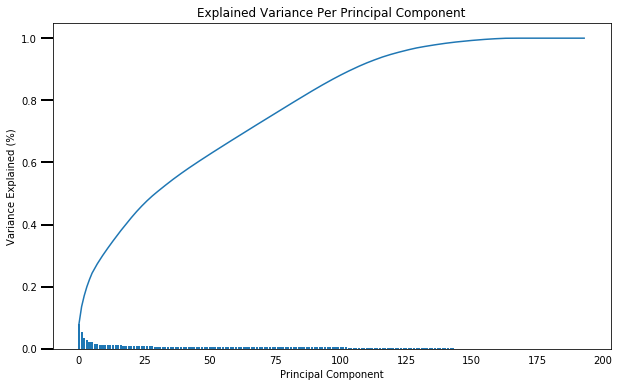

In [51]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)



In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.
X = StandardScaler().fit_transform(azdias_scaled)
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

In [53]:
for i in np.arange(10, 101, 10):
    print(
        f'{i} components explain {pca.explained_variance_ratio_[:i].sum()} of variance.'
    )

10 components explain 0.2997829980768805 of variance.
20 components explain 0.41197448185262125 of variance.
30 components explain 0.4991034693983141 of variance.
40 components explain 0.564343363670903 of variance.
50 components explain 0.6209058491026359 of variance.
60 components explain 0.6741990263033497 of variance.
70 components explain 0.7264522017750115 of variance.
80 components explain 0.7781445699601242 of variance.
90 components explain 0.8285791841089727 of variance.
100 components explain 0.8748282109206713 of variance.


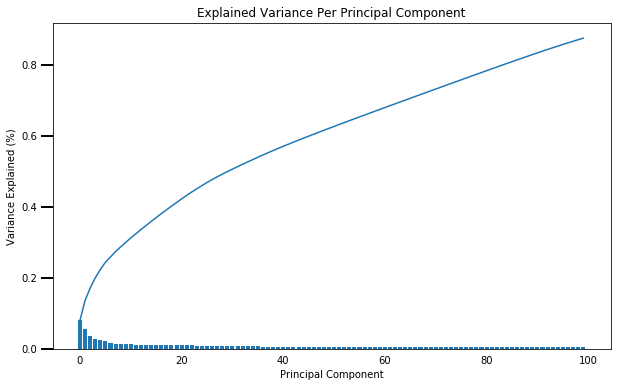

In [54]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

We will work with 100 components that explain the 87% of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_weights(pca, feature_columns, component_number):
    component = pd.DataFrame(pca.components_, columns=list(feature_columns)).iloc[component_number-1]
    component.sort_values(ascending=False, inplace=True)
    component = pd.concat([component.head(5), component.tail(5)])
    component.plot(
        kind='bar',
        title=f'Most {5 * 2} weighted features for PCA component {component_number}',
        figsize=(12, 6),
    )
    plt.show()
    return component


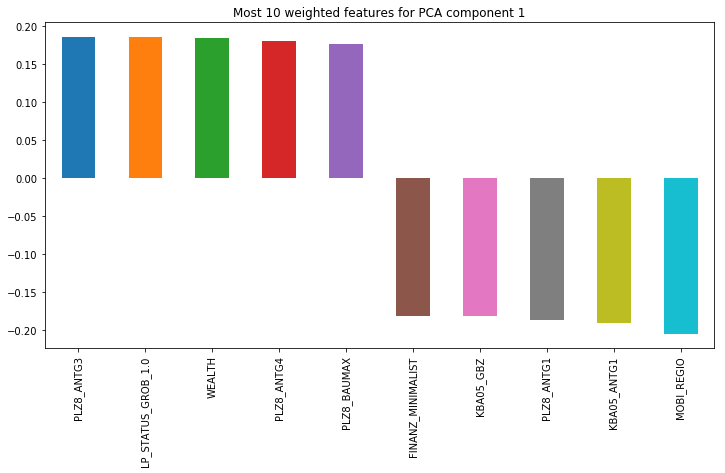

PLZ8_ANTG3            0.185848
LP_STATUS_GROB_1.0    0.185550
WEALTH                0.184533
PLZ8_ANTG4            0.180549
PLZ8_BAUMAX           0.176289
FINANZ_MINIMALIST    -0.180900
KBA05_GBZ            -0.181822
PLZ8_ANTG1           -0.186257
KBA05_ANTG1          -0.190740
MOBI_REGIO           -0.204381
Name: 0, dtype: float64

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

positive_values = []
negative_values = []

weights_1 = get_weights(pca, azdias_scaled.columns, 1)
weights_1

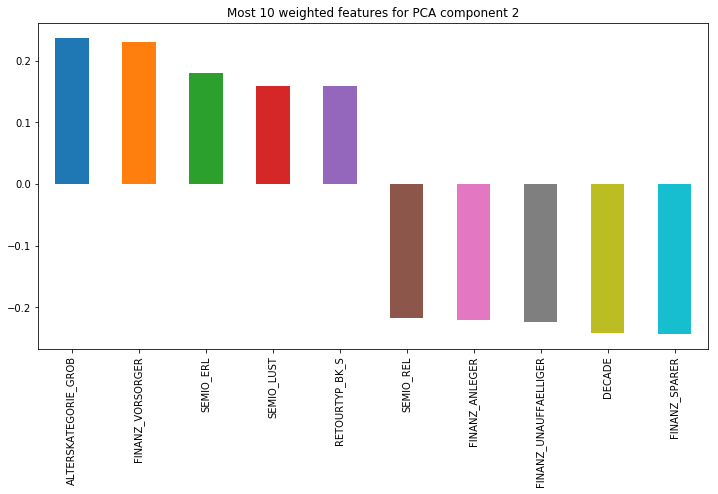

ALTERSKATEGORIE_GROB     0.237145
FINANZ_VORSORGER         0.229620
SEMIO_ERL                0.179343
SEMIO_LUST               0.159451
RETOURTYP_BK_S           0.159117
SEMIO_REL               -0.217514
FINANZ_ANLEGER          -0.221402
FINANZ_UNAUFFAELLIGER   -0.223920
DECADE                  -0.242354
FINANZ_SPARER           -0.243468
Name: 1, dtype: float64

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_2 = get_weights(pca, azdias_scaled.columns, 2)
weights_2


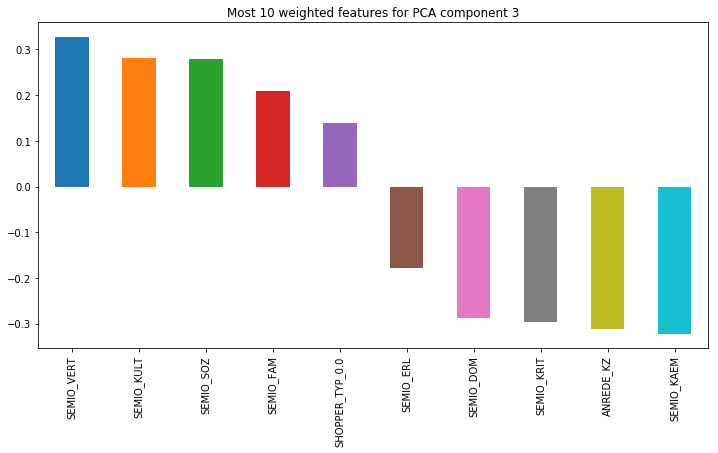

SEMIO_VERT         0.327144
SEMIO_KULT         0.281252
SEMIO_SOZ          0.278179
SEMIO_FAM          0.208797
SHOPPER_TYP_0.0    0.137986
SEMIO_ERL         -0.179181
SEMIO_DOM         -0.288957
SEMIO_KRIT        -0.295793
ANREDE_KZ         -0.311395
SEMIO_KAEM        -0.322055
Name: 2, dtype: float64

In [58]:
weights_3 = get_weights(pca, azdias_scaled.columns, 3)
weights_3

In [59]:
positive_values = weights_1.head().keys().tolist() + weights_2.head().keys().tolist() + weights_3.head().keys().tolist()
negative_values = weights_1.tail().keys().tolist() + weights_2.tail().keys().tolist() + weights_3.tail().keys().tolist()

print(positive_values)
print(negative_values)

['PLZ8_ANTG3', 'LP_STATUS_GROB_1.0', 'WEALTH', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'SEMIO_ERL', 'SEMIO_LUST', 'RETOURTYP_BK_S', 'SEMIO_VERT', 'SEMIO_KULT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SHOPPER_TYP_0.0']
['FINANZ_MINIMALIST', 'KBA05_GBZ', 'PLZ8_ANTG1', 'KBA05_ANTG1', 'MOBI_REGIO', 'SEMIO_REL', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'DECADE', 'FINANZ_SPARER', 'SEMIO_ERL', 'SEMIO_DOM', 'SEMIO_KRIT', 'ANREDE_KZ', 'SEMIO_KAEM']


### Discussion 2.3: Interpret Principal Components

1.  First Principal Component

    -   Positive Values:
        -   PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
        -   LP_STATUS_GROB_1.0: Social status, low-income earners
        -   WEALTH: Household wealthy
        -   PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
        -   PLZ8_BAUMAX: Most common building type within the PLZ8 region
    -   Negative Values:
        -   FINANZ_MINIMALIST: Financial typology - low financial interest
        -   KBA05_GBZ: Number of buildings in the microcell
        -   PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
        -   KBA05_ANTG1: Number of 1-2 family houses in the microcell
        -   MOBI_REGIO: Movement patterns
2.  Second Principal Component

    -   Positive Values:
        -   ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
        -   FINANZ_VORSORGER: Financial typology - be prepared
        -   SEMIO_ERL: personality typology - Event-oriented
        -   SEMIO_LUST: personality typology - Sensual-minded
        -   RETOURTYP_BK_S: Return type
    -   Negative Values:
        -   SEMIO_REL: Personality typology - Religious
        -   FINANZ_ANLEGER: Financial Typology - Investor
        -   FINANZ_UNAUFFAELLIGER: Financial Typology - inconspicuous
        -   DECADE: Generation
        -   FINANZ_SPARER: Financial Typology - Money saver
3.  Third Principal Component

    -   Positive Values:
        -   SEMIO_VERT: personality typology - dreamful
        -   SEMIO_KULT: personality typology - cultural-minded
        -   SEMIO_SOZ: personality typology - socially-minded
        -   SEMIO_FAM: personality typology - family-minded
        -   SHOPPER_TYP_0.0: Shopper typology - external supplied hedonists
    -   Negative Values:
        -   SEMIO_ERL: personality typology - Event-oriented
        -   SEMIO_DOM: personality typology - dominant-minded
        -   SEMIO_KRIT: personality typology - critical-minded
        -   ANREDE_KZ: Gender
        -   SEMIO_KAEM: personality typology - combative attitude



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...

centers = list(range(2, 30, 2)) 
print(centers) 
scores = []
for center in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.    
    # Obtain a score related to the model fitpd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
    score = np.abs(model.score(X_pca))
    scores.append(score)  
    

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]


In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, centers[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(centers, scores, linestyle='--', marker='o');


In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=26)
model = kmeans.fit(X_pca)
population_prediction = model.predict(X_pca)


In [ ]:
def create_kmeans_plot(data, labels): 
    fig = plt.figure(figsize=(28, 12));
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

In [ ]:
create_kmeans_plot(X_pca, population_prediction)


### Discussion 3.1: Apply Clustering to General Population

We applied KMeans to the clean population data we iterate from 2 to 28 centers and as we can see in then above plot the elbow is showed better in the point 26. So this is the number of clusters we will use for creating the model ad for segment the data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers


In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_data = clean_data(customers, feat_info_test)


In [ ]:
customer_columns = customer_data.columns


In [ ]:
customer_imputer = imputer.transform(customer_data)
customer_imputer = pd.DataFrame(customer_imputer, columns=customer_columns)

In [ ]:
customer_imputer.isnull().sum().sum()
customer_imputer


In [ ]:
customer_scaled = scaler.transform(customer_imputer)
customer_scaled = pd.DataFrame(customer_scaled, columns=customer_columns)
customer_scaled.head()

In [ ]:
customers_pca = pca.transform(customer_scaled)


In [ ]:
#cluster predictions
customer_prediction= model.predict(customers_pca)

In [ ]:
create_kmeans_plot(customers_pca, customer_prediction)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
clusterno_predicted_general = pd.Series(population_prediction).value_counts().sort_index()

clusterno_predicted_customers = pd.Series(customer_prediction).value_counts().sort_index()

df_both = pd.concat([clusterno_predicted_general, clusterno_predicted_customers], axis=1).reset_index()
df_both.columns = ['clusters', 'pred_general', 'pred_customers']

df_both


In [ ]:
df_both['general_prop'] = (df_both['pred_general']/df_both['pred_general'].sum()*100).round(3)
df_both['customers_prop'] = (df_both['pred_customers']/df_both['pred_customers'].sum()*100).round(3)

# calculating the diferences between the two proportions
df_both['difference'] = df_both['general_prop'] - df_both['customers_prop']
df_both

In [ ]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(1,1,1)

ax = df_both['general_prop'].plot(x=df_both['clusters'], kind='bar',color='orange',width=-0.3, align='edge',position=0)
ax = df_both['customers_prop'].plot(x=df_both['clusters'], kind='bar',color='blue',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Proportions (%)', fontsize=15)
ax.tick_params(axis = 'x', which = 'major', labelsize = 14)
plt.xticks(rotation=360,)

plt.legend(('General population %', 'Customer population %'),fontsize=15)
plt.title('Comparing the proportion of general and customer populations(%) in each clusters',fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Barplot", fontsize=15)
plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrepresented_customers = scaler.inverse_transform([pca.inverse_transform(model.cluster_centers_[3])]).round(0)


In [ ]:
overrepresented_customers_df=pd.DataFrame({"feature":azdias_scaled.columns, "overrepresented_customers":overrepresented_customers[0]})
overrepresented_customers_df

In [ ]:
overrepresented_customers_df[overrepresented_customers_df["feature"].isin(positive_values)]


### Overrepresented Customers positive values

Exploring the positive correlation features of the 2 principal componentes we could say that in the cluster number 4 the customers overrepresented are:

-   PLZ8_ANTG3 == 1.0 - Number of 6-10 family houses in the PLZ8 region - lower share of 6-10 family homes
-   LP_STATUS_GROB_1 == 0,0 - Social status - low-income earners
-   WEALTH == 2.0 - Prosperous Households
-   PLZ8_ANTG4 == 0.0 - Number of 10+ family houses in the PLZ8 region - no 10+ family homes
-   PLZ8_BAUMAX == 1.0 - Most common building type within the PLZ8 region - mainly 1-2 family homes
-   ALTERSKATEGORIE_GROB == 3 - '46 - 60 years old'
-   FINANZ_VORSORGER == 4.0 - be prepared - low
-   SEMIO_LUST == 5.0 - sensual-minded - low affinity
-   RETOURTYP_BK_S == 4.0 - conservative Low-Returner
-   SEMIO_VERT == 5.0 - dreamful - low affinity

In [ ]:
overrepresented_customers_df[overrepresented_customers_df["feature"].isin(negative_values)]


### Underrepresented Customers positive values

Exploring the positive features of the 2 principal componentes we could say that in the cluster number 5 the customers underrepresented are:

-   PLZ8_ANTG3 == 2.0 - Number of 6-10 family houses in the PLZ8 region - average share of 6-10 family homes
-   LP_STATUS_GROB_1 == 1.0 - Social status - low-income earners
-   WEALTH == 4.0 - Less Affluent Households
-   PLZ8_ANTG4 == 1.0 - Number of 10+ family houses in the PLZ8 region - lower share of 10+ family homes
-   PLZ8_BAUMAX == 3.0 - Most common building type within the PLZ8 region - mainly 6-10 family homes
-   ALTERSKATEGORIE_GROB == 2 - '30 - 45 years old'
-   FINANZ_VORSORGER == 2.0 - be prepared - high
-   SEMIO_LUST == 3.0 - sensual-minded high affinity
-   RETOURTYP_BK_S == 2.0 - demanding Heavy-Returner
-   SEMIO_VERT == 2.0 - dreamful - very high affinity### Overrepresented Customers negative values

Exploring the negative correlation features of the 2 principal componentes we could say that in the cluster number 4 the customers overrepresented are:

-   FINANZ_MINIMALIST == 5.0 - low financial interest very low
-   KBA05_GBZ == 4.0 - Number of buildings in the microcell 17-22 buildings
-   PLZ8_ANTG1 == 3.0 - Number of 1-2 family houses in the PLZ8 region - high share of 1-2 family homes
-   KBA05_ANTG1 == 3.0 - Number of 1-2 family houses in the microcell - very high share of 1-2 family homes
-   MOBI_REGIO == 4.0 - Movement patterns - low movement
-   SEMIO_REL == 3.0 - religious - very high affinity
-   FINANZ_ANLEGER == 2.0 - investor - high
-   FINANZ_UNAUFFAELLIGER == 2.0 - inconspicuous - high
-   DECADE == 4.0 - From 40's - 50's
-   FINANZ_SPARER == 2.0 - money-saver - high

#### Kind of People

Looking to the value of the principal 2 components features positive and negative correlation, we could infer that the people overrepresented in the cluster number 4 are:

Persons from 46 to 60 years old, who are low-income earners but from prosperous households, they're conservatives in buying things, not dreamful and probably live in a part of the PLZ8 region where there're 1-2 family homes.

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented_customers = scaler.inverse_transform([pca.inverse_transform(model.cluster_centers_[9])]).round(0)


In [ ]:
underrepresented_customers_df=pd.DataFrame({"feature":azdias_scaled.columns, "underrepresented_customers":underrepresented_customers[0]})

underrepresented_customers_df

In [ ]:
underrepresented_customers_df[underrepresented_customers_df["feature"].isin(positive_values)]


### Underrepresented Customers positive values

Exploring the positive features of the 2 principal componentes we could say that in the cluster number 5 the customers underrepresented are:

-   PLZ8_ANTG3 == 2.0 - Number of 6-10 family houses in the PLZ8 region - average share of 6-10 family homes
-   LP_STATUS_GROB_1 == 1.0 - Social status - low-income earners
-   WEALTH == 4.0 - Less Affluent Households
-   PLZ8_ANTG4 == 1.0 - Number of 10+ family houses in the PLZ8 region - lower share of 10+ family homes
-   PLZ8_BAUMAX == 3.0 - Most common building type within the PLZ8 region - mainly 6-10 family homes
-   ALTERSKATEGORIE_GROB == 2 - '30 - 45 years old'
-   FINANZ_VORSORGER == 2.0 - be prepared - high
-   SEMIO_LUST == 3.0 - sensual-minded high affinity
-   RETOURTYP_BK_S == 2.0 - demanding Heavy-Returner
-   SEMIO_VERT == 2.0 - dreamful - very high affinity

In [ ]:
underrepresented_customers_df[underrepresented_customers_df["feature"].isin(negative_values)]


### Underrepresented Customers negative values

Exploring the negative correlation features of the 2 principal componentes we could say that in the cluster number 5 the customers underrepresented are:

-   FINANZ_MINIMALIST == 1.0 - low financial interest - low
-   KBA05_GBZ == 2.0 - Number of buildings in the microcell - 3-4 buildings
-   PLZ8_ANTG1 == 2.0 - Number of 1-2 family houses in the PLZ8 region - high share of 1-2 family homes
-   KBA05_ANTG1 == 1.0 - Number of 1-2 family houses in the microcell - average share of 1-2 family homes
-   MOBI_REGIO == 2.0 - Movement patterns - very low movement
-   SEMIO_REL == 5.0 - religious - low affinity
-   FINANZ_ANLEGER == 5.0 - investor - average
-   FINANZ_UNAUFFAELLIGER == 4.0 - inconspicuous - average
-   DECADE == 6 - 60's - 70's
-   FINANZ_SPARER == 2.0 - money-saver - high

#### Kind of People

Looking to the value of the principal 2 components features positive and negative correlation, we could infer that the people underrepresented in the cluster number 5 are:

Persons from 30 to 45 years old, who have low-income less affluent households, they're demanding heavy-returning in buying things, they are dreamful and probably live in a part of the PLZ8 region with 6-10 family homes.

### Discussion 3.3: Compare Customer Data to Demographics Data

As we saw above, we used unsupervised learning methods for separating in clusters the customers. We cleaned and transformed the data to have it ready to begin with the analysis, we used PCA to reduce the dimensionality reduction and create a KMean model.

We applied it to the general population, then to the customer population and finally compared the resulting data getting conclusions of overrepresented data and underrepresented customer clusters data.

Overrepresented cluster:

-   Persons from 46 to 60 years old, who are low-income earners but from prosperous households, they're conservatives in buying things, not dreamful and probably live in a part of the PLZ8 region where there're 1-2 family homes.

-   This segment is relatively popular with the mail-order sales company.

Underrepresented cluster: (This segment is relatively unpopular with the company)

-   Persons from 30 to 45 years old, who have low-income less affluent households, they're demanding heavy-returning in buying things, they are dreamful and probably live in a part of the PLZ8 region with 6-10 family homes.

-   This segment is unpopular in mail-orders sales with the company, probably because they're heavy-returners, low income and live in less affluent households.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.